# Hyperspace Explorer: LightGBM/Optuna Workflow

This notebook demonstrates a full machine learning workflow for tabular data, including preprocessing (accomodating for class imbalances and categorical data), hyperparameter optimization, model evaluation, and interpretation.

**Workflow overview:**
- Load and preprocess data from Excel (.xlsx)
- Define experiment configuration
- Run hyperparameter search with Optuna and LightGBM
- Analyze and visualize results
- Train and evaluate ensemble models
- Interpret model predictions with SHAP

---

# Stage 0: Import Modules
Import all required external libraries and internal modules for data processing, modeling, and visualization.

---

In [23]:
import os
import sys

# Force CPU only for all following imports and execution
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
sys.path.append(os.path.abspath("../src"))

import optuna
from pathlib import Path
import pandas as pd

from hyperspace_explorer.components.config import Config
from hyperspace_explorer.components.ensemble_study_runner_softvote import EnsembleStudyRunner
from hyperspace_explorer.components.lightgbm_study_runner import LightGBMStudyRunner
from hyperspace_explorer.components.study_utils import (
    suppress_noise,
    set_determinism,
    configure_matplotlib_backend,
    prepare_output_dirs,
    load_dataset,
    create_dataset,
)
from hyperspace_explorer.components.preprocess import (
    validate_features,
    set_categorical,
    create_target,
    report_missing_values,
    split_data,
)
from hyperspace_explorer.components.vizualizations import (
    plot_feature_amount_frequency_loocv,
    plot_feature_selection_frequency_loocv,
    plot_average_roc_curve_loocv,
    plot_average_roc_curve_ensemble,
    plot_shap_summary_loocv,
    plot_shap_summary_ensemble,
    plot_shap_dependence_ensemble,
    plot_shap_feature_importance_ensemble,
    plot_iterations_histogram_loocv,
    visualize_ensemble_results,
    plot_shap_decision_ensemble, plot_class_distribution,
    plot_confusion_matrix_loocv,
    plot_confusion_matrix_ensemble
)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Stage 0: Configuration, Directories, and Data Loading
Load the experiment configuration, set up output directories, and import the dataset. This stage further ensures reproducibility and organizes outputs for later analysis.

---

In [24]:
config = Config(Path(os.path.abspath("../configs/hyperspace_explorer-lgbm-1m-v1.0_CC_PGIC.json")))
suppress_noise()
rng = set_determinism(config.random_seed)
configure_matplotlib_backend(config.plt_backend)
prepare_output_dirs(config)
data = load_dataset(config.file_name)

Loading dataset from ../data/input/raw_new.xlsx...
Data Loaded. Shape: (96, 54)


# Stage 0: Data Preprocessing
Validate and preprocess the dataset:
- Check feature availability
- Define categorical columns
- Create the binary target
- Report missing values
- Split the data into training and holdout sets
- Calculate class imbalance for model weighting

---

In [25]:
# Identify existing features
existing_features = validate_features(data, config.features)
data = set_categorical(data, config.categorical_features)

# Create Binary Target Column
data = create_target(data, config.target_source, config.target)
report_missing_values(data, existing_features)

# Prepare feature and target datasets
all_X = data[existing_features].copy().sort_index(axis=1).reset_index(drop=True)
all_y = data[config.target].copy()

X, holdout_X, y, holdout_y = split_data(all_X, all_y, config.hold_out, config.random_seed)

# Calculate and report class imbalance
class_counts = y.value_counts()
plot_class_distribution(class_counts=class_counts)
config.scale_pos_weight = class_counts.get(0, 0) / class_counts.get(1, 1)
print(f"Calculated scale_pos_weight for LightGBM: {config.scale_pos_weight:.3f}")

⚠️ Column 'pain_mech_neurop' has 5 missing values.
⚠️ Column 'expec' has 1 missing values.
⚠️ Column 'sleep' has 7 missing values.
⚠️ Column 'comorb' has 1 missing values.

Number of records in the training/test set: 64
Number of records in the holdout set: 8

Class distribution in the training/test set:
pgic_lws_3m_01
0    42
1    22
Name: count, dtype: int64

Class distribution in the holdout set:
pgic_lws_3m_01
0    5
1    3
Name: count, dtype: int64
Class distribution in training set: {0: 42, 1: 22}
Calculated scale_pos_weight for LightGBM: 1.909


# Stage 1: Hyperspace Exploration
Perform hyperparameter optimization using Optuna and LightGBM with leave-one-out cross-validation (LOOCV). This stage systematically explores the parameter space to identify optimal model settings.

---

In [26]:
loocv_runner = LightGBMStudyRunner(config, X, y)

loocv_runner.create_study()
loocv_runner.explore_hyperspace()
loocv_runner.summarize_results()

/app/MLmodel/src/hyperspace_explorer/components/lightgbm_study_runner.py:45: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler = optuna.samplers.QMCSampler(


  0%|          | 0/10000 [00:00<?, ?it/s]

📈 Number of finished trials: 10000
✅ Number of successful trials: 830


# Analyze Hyperspace Exploration Results
Summarize and visualize the results of the hyperparameter search:
- Review model scores and selected features
- Analyze parameter distributions
- Visualize feature selection frequencies and coverage

---

In [27]:
loocv_runner.summarize_scores()
loocv_runner.show_selected_features()
categorical_param_df, numerical_param_df = loocv_runner.analyze_parameters()
feature_stats_df, final_features = loocv_runner.analyze_feature_rankings()


🏅 Top Trials by Objective Scores:


,Trial ID,F1_Score_0,F1_Score_1,ROC_AUC
0,1506,0.736842,0.615385,0.763636
1,2164,0.736842,0.615385,0.763636
2,2540,0.761905,0.545455,0.745455
3,3370,0.761905,0.545455,0.745455
4,3728,0.800000,0.666667,0.654545
5,4014,0.736842,0.615385,0.763636
6,4750,0.736842,0.615385,0.763636
7,5156,0.736842,0.615385,0.763636
8,5272,0.761905,0.545455,0.745455
9,7105,0.818182,0.600000,0.709091



🧠 Selected Features for Top Trials:


,Trial ID,0,1,2,3,4,5
0,1506,age,expec,self_eff,bmi,comorb,sleep
1,2164,age,expec,self_eff,bmi,comorb,sleep
2,2540,age,pain_mech_nocipl,comorb,sleep,psy_fac,None
3,3370,expec,age,psy_fac,comorb,bmi,None
4,3728,age,psy_fac,comorb,expec,pain_area,bmi
5,4014,age,expec,self_eff,bmi,comorb,sleep
6,4750,age,expec,self_eff,bmi,comorb,sleep
7,5156,age,expec,self_eff,bmi,comorb,sleep
8,5272,expec,age,psy_fac,comorb,bmi,None
9,7105,age,pain_mech_nocipl,bmi,sleep,expec,psy_fac



🔣 Unique Values for Categorical Parameters:


,grow_policy
0,leaf
1,depthwise



📈 Min/Max Range of Numerical Parameters:


,subsample,learning_rate,feature_fraction,max_depth,min_child_weight
min,0.200684,0.112799,0.200391,3,2
max,0.999902,0.998737,0.985938,9,7



📊 Feature Selection Stats Across Trials:


,Feature,Frequency,RankSum,RankSum_Per_Frequency
0,age,827,849,1.026602
1,pain_mech_nocipl,384,951,2.476562
2,psy_fac,593,1825,3.077572
3,expec,274,851,3.105839
4,pain_mech_neurop,418,1330,3.181818
5,comorb,627,2369,3.778309
6,self_eff,217,835,3.847926
7,sleep,210,983,4.680952
8,pain_area,34,173,5.088235
9,bmi,161,833,5.173913



📐 RankSum_Per_Frequency Cutoff (coverage=80%): 5

🏁 Final Feature Set (after cutoff):


,Feature,Frequency,RankSum,RankSum_Per_Frequency
0,age,827,849,1.026602
1,pain_mech_nocipl,384,951,2.476562
2,psy_fac,593,1825,3.077572
3,expec,274,851,3.105839
4,pain_mech_neurop,418,1330,3.181818
5,comorb,627,2369,3.778309
6,self_eff,217,835,3.847926
7,sleep,210,983,4.680952


🧠 Final Selected Features: ['age', 'pain_mech_nocipl', 'psy_fac', 'expec', 'pain_mech_neurop', 'comorb', 'self_eff', 'sleep']


In [28]:
trial_df_long = (
    pd.DataFrame([
        (trial.number, feat)
        for trial in loocv_runner.study.trials
        if trial.state == optuna.trial.TrialState.COMPLETE
        for feat in trial.user_attrs["selected_features"]
    ], columns=["Trial", "Feature"])
)

frequency_df_sorted, feature_amount_freq, cumulative_percentages, selected_features_coverage_pct = (
    loocv_runner.analyze_feature_frequencies(
        trial_df_long=trial_df_long,
        feat_stats_df=feature_stats_df,
        final_features=final_features
    )
)


📊 Frequency of number of features selected per trial:
1       2
3     245
4      67
5     355
6      97
7      44
8       7
9       8
10      1
11      3
13      1
Name: count, dtype: int64

📈 Cumulative % of feature set sizes across trials:
1       0.240964
3      29.759036
4      37.831325
5      80.602410
6      92.289157
7      97.590361
8      98.433735
9      99.397590
10     99.518072
11     99.879518
13    100.000000
Name: count, dtype: float64

✅ Coverage of selected features across all feature picks: 100.00%

📋 Top features sorted by frequency and selection status:


,Feature,Frequency,RankSum,RankSum_Per_Frequency,Selected,Cumulative_Frequency,Cumulative_Percentage
0,age,827,849,1.026602,True,827,23.295775
5,comorb,627,2369,3.778309,True,1454,40.957746
2,psy_fac,593,1825,3.077572,True,2047,57.661972
4,pain_mech_neurop,418,1330,3.181818,True,2465,69.436620
1,pain_mech_nocipl,384,951,2.476562,True,2849,80.253521
3,expec,274,851,3.105839,True,3123,87.971831
6,self_eff,217,835,3.847926,True,3340,94.084507
7,sleep,210,983,4.680952,True,3550,100.000000


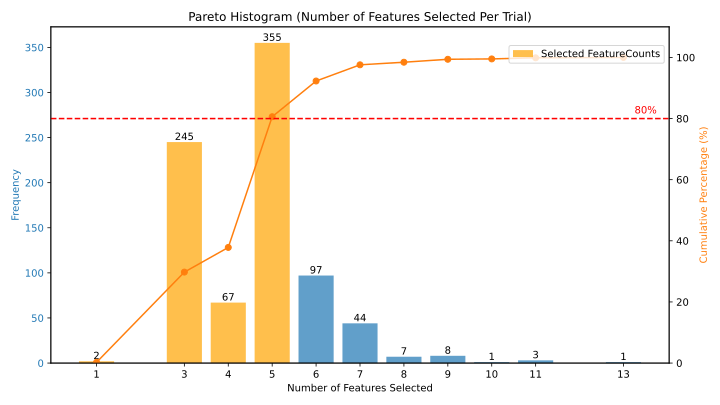

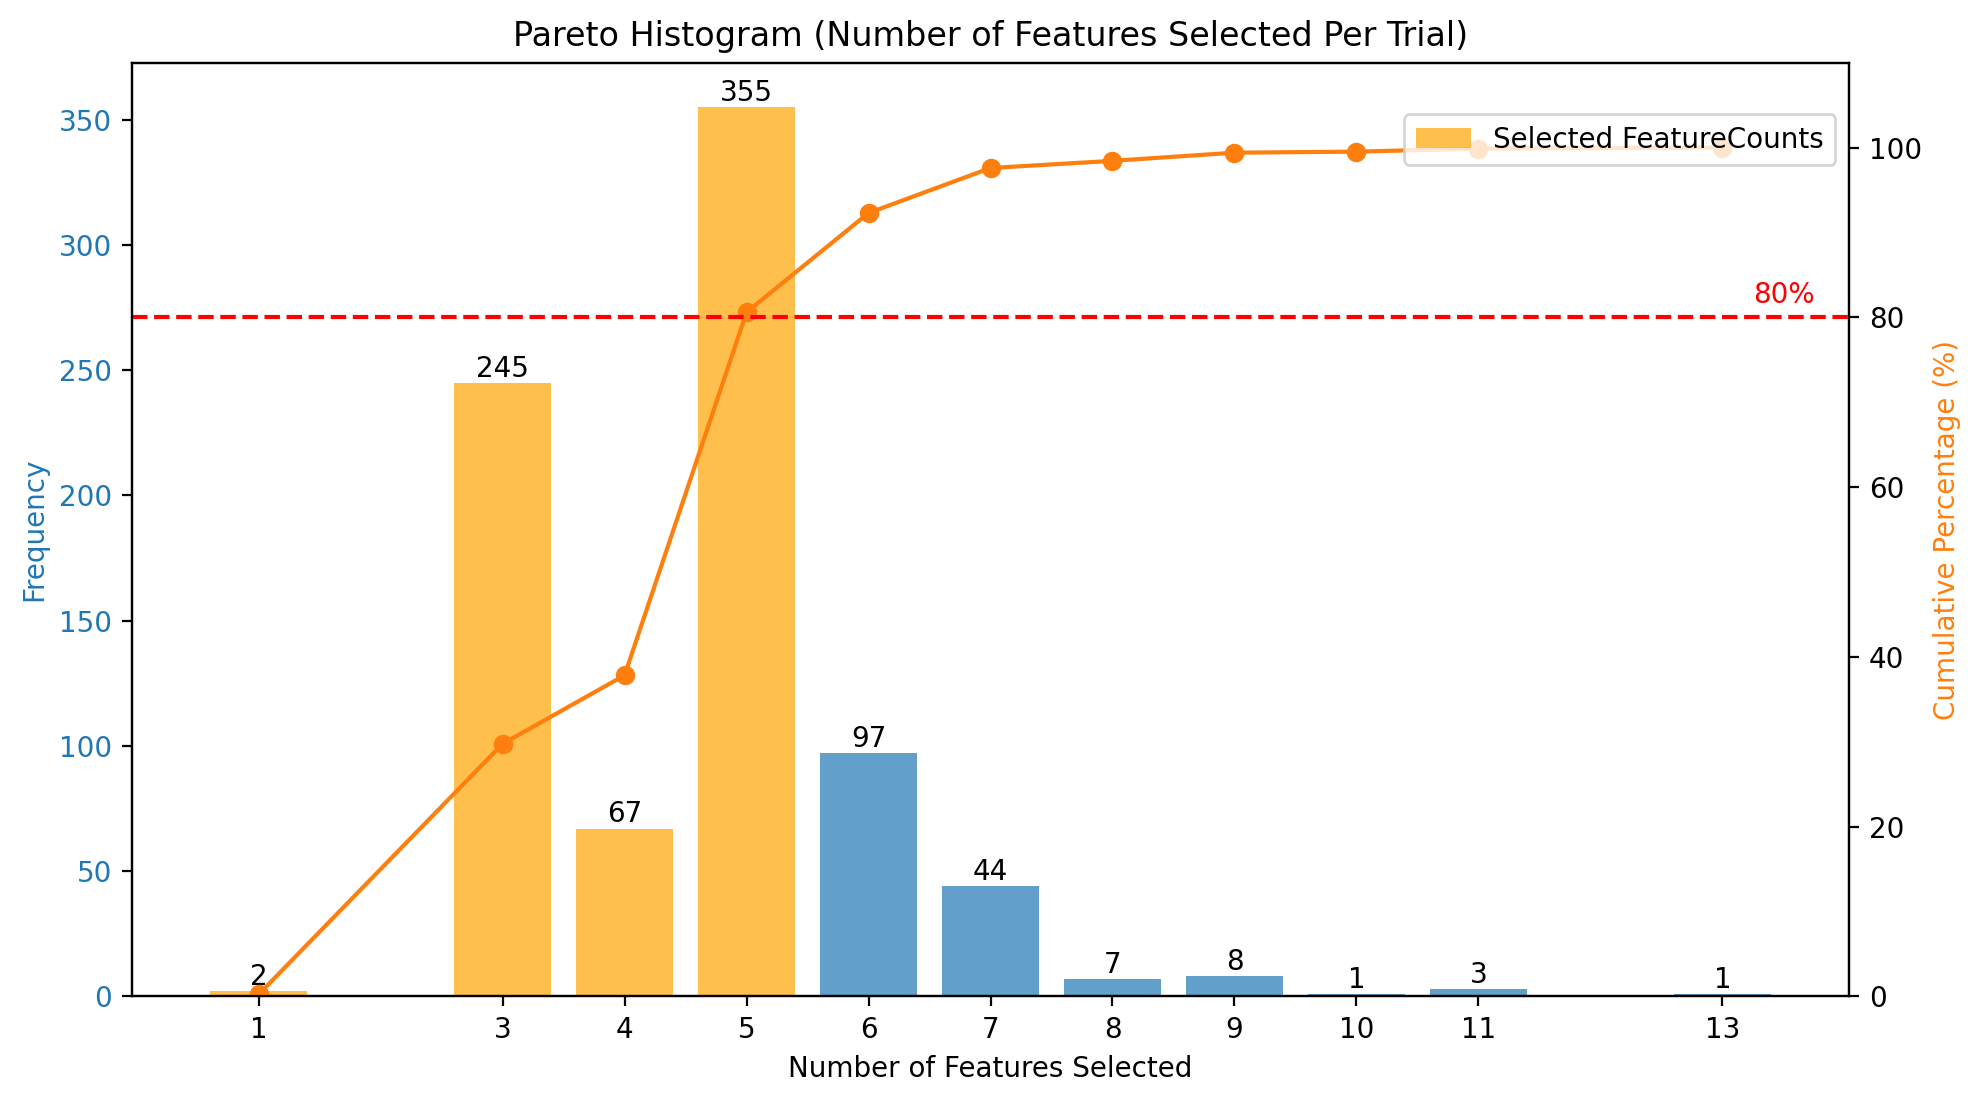

In [29]:
# Visualize feature amount frequency and cumulative percentages
plot_feature_amount_frequency_loocv(
    feature_amount_freq=feature_amount_freq,
    cumulative_percentages=cumulative_percentages,
    x_positions=feature_amount_freq.index,
    config=config,
    threshold_pct=config.feat_count_cov
)
# This plot shows how often different numbers of features are selected across LOOCV trials, and the cumulative percentage. Useful for understanding feature selection stability.

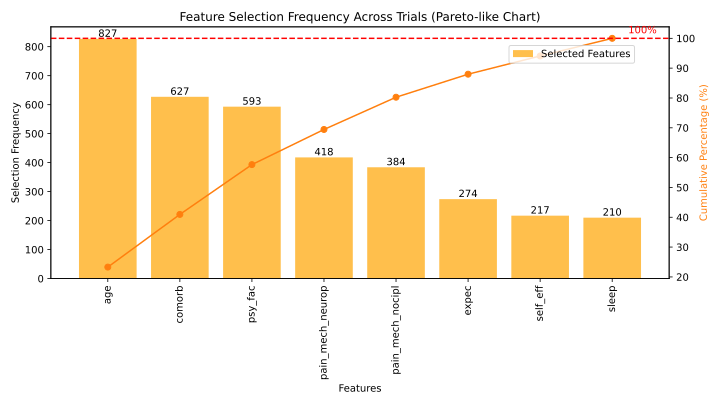

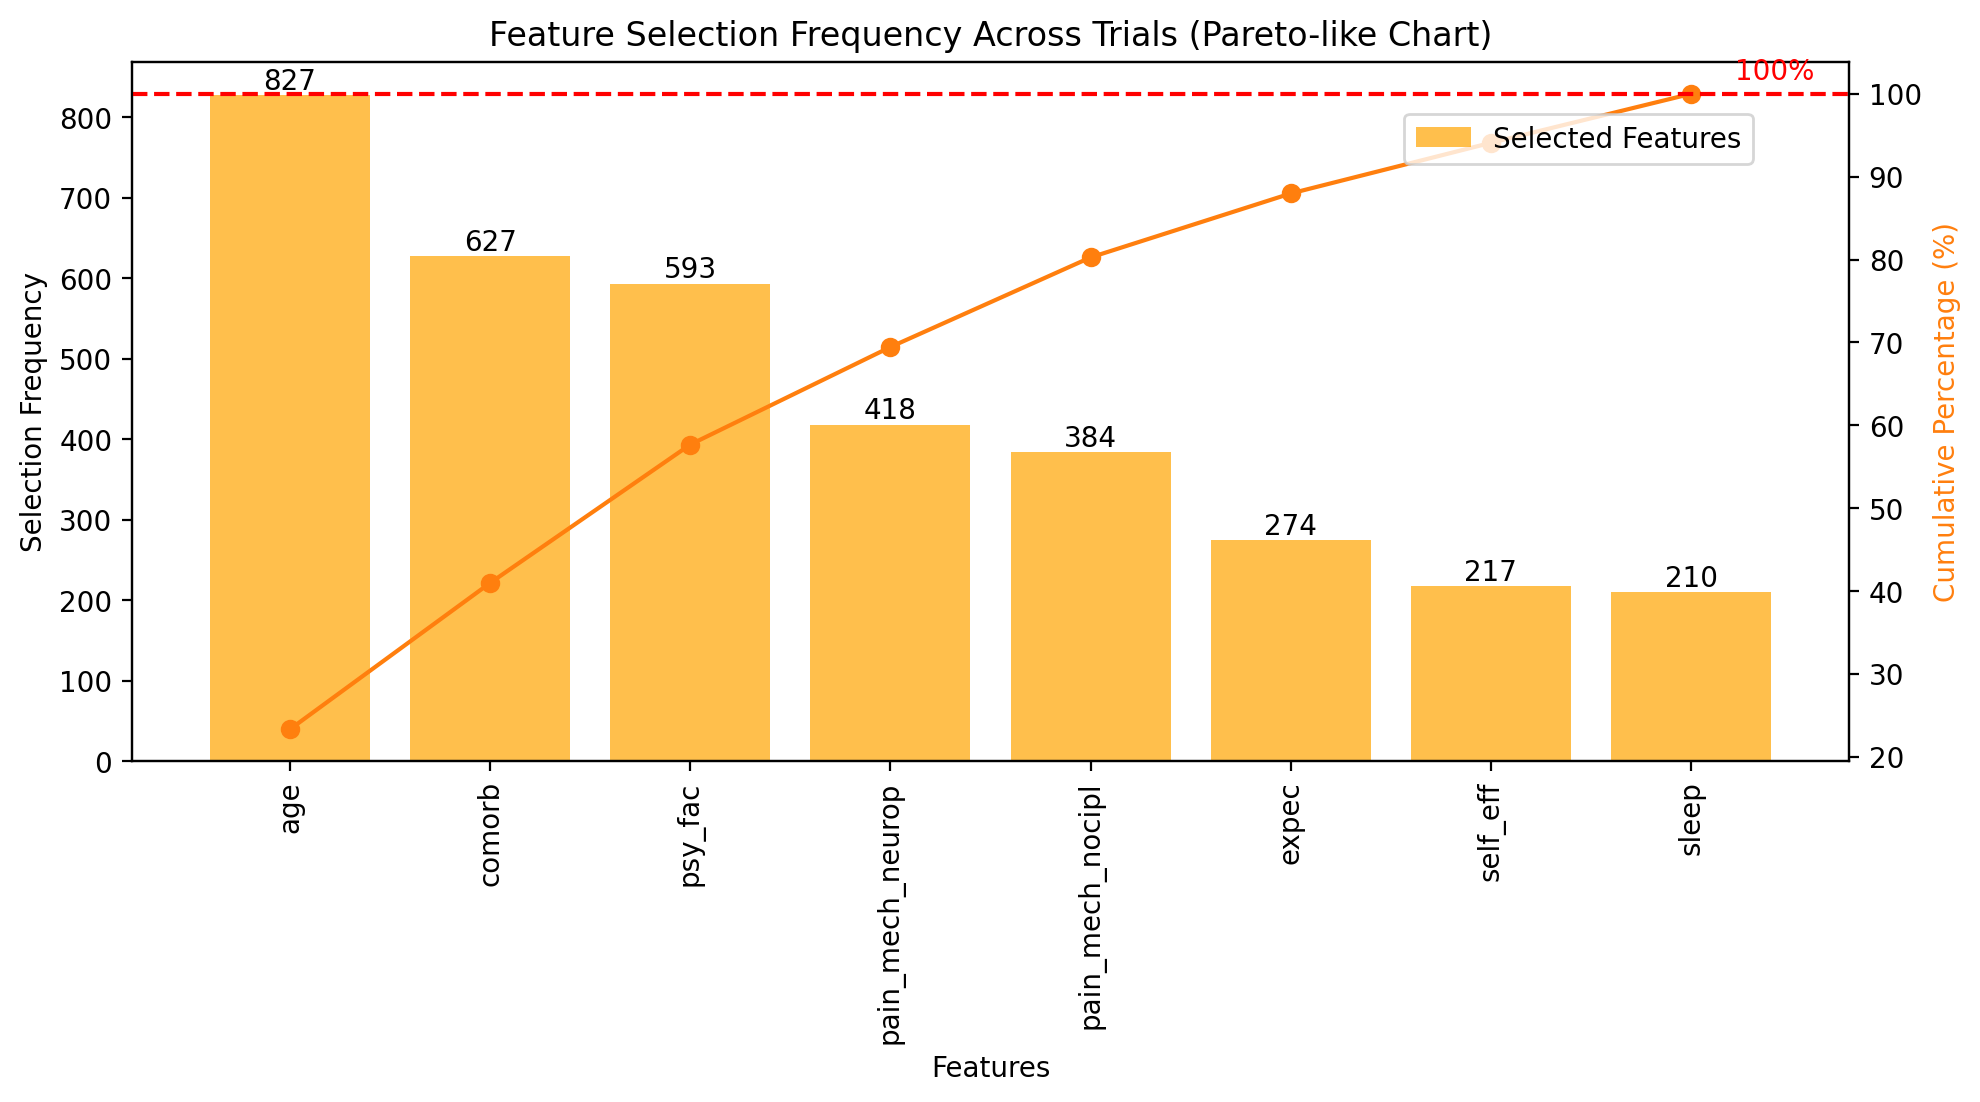

In [30]:
plot_feature_selection_frequency_loocv(
    frequency_df_sorted=frequency_df_sorted,
    selected_features_coverage_pct=selected_features_coverage_pct,
    config=config
)
# This plot shows how frequently each feature was selected across all LOOCV trials, and the overall coverage. It helps identify consistently important features.

# Stage 2: Final LOOCV Study
Conduct a final LOOCV study using the best features and parameters identified. Summarize performance metrics and generate detailed classification reports for robust model evaluation.

---

In [31]:
final_study = loocv_runner.explore_final_hyperspace(
    data=X[final_features],
    target=y,
)

  0%|          | 0/200 [00:00<?, ?it/s]

🧪 Final Study Results
📊 Total trials run: 200
✅ Successful trials: 200


In [32]:
final_scores_df = loocv_runner.get_final_scores_df(final_study)
best_final_params, best_trial = loocv_runner.get_best_final_trial_params(final_study, final_scores_df)

# Print aggregate metrics
loocv_runner.summarize_final_classification_report(final_study, y)

# Print full report across all best predictions
loocv_runner.summarize_combined_report(final_study, y)

📋 Final Best Trials (sorted):


,Trial ID,F1_Score_0,F1_Score_1,ROC_AUC
0,5,0.954545,0.900000,0.935065
2,98,0.954545,0.900000,0.935065
4,128,0.954545,0.900000,0.935065
5,183,0.954545,0.900000,0.935065
3,119,0.942529,0.878049,0.974026
1,87,0.943820,0.871795,0.965368



🏆 Best Final Trial ID: 5
⚙️ Best Final Params:
    verbose: -1
    objective: binary
    n_jobs: 1
    num_threads: 1
    tree_learner: serial
    deterministic: True
    seed: 42
    feature_fraction_seed: 42
    data_random_seed: 42
    max_bin: 255
    metric: binary_logloss
    boosting_type: gbdt
    is_unbalance: False
    scale_pos_weight: 1.9090909090909092
    force_col_wise: True
    subsample: 0.846769911814953
    learning_rate: 0.3826678333926581
    feature_fraction: 0.2771166489323586
    max_depth: 7
    min_child_weight: 4
    grow_policy: depthwise

📊 Average Classification Report Across Best Trials:
              precision    recall  f1-score   support

           0      0.909     0.996     0.951        42
           1      0.991     0.811     0.892        22
    accuracy                          0.932        64
   macro avg      0.950     0.903     0.921        64
weighted avg      0.938     0.932     0.930        64

📈 Overall Classification Report Across All Best

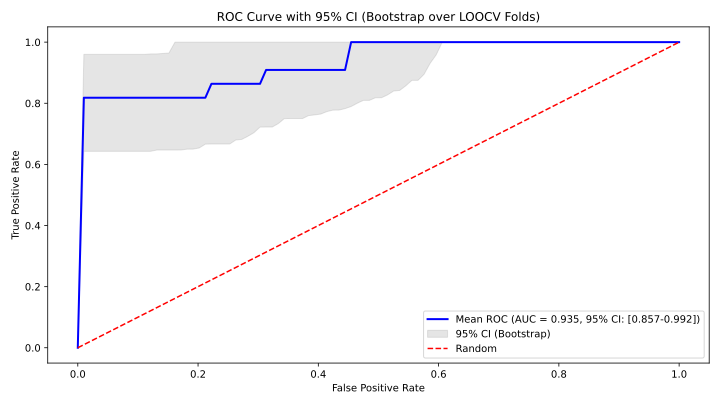

In [33]:
# Visualize average ROC curve for LOOCV
plot_average_roc_curve_loocv(final_study, y, config)

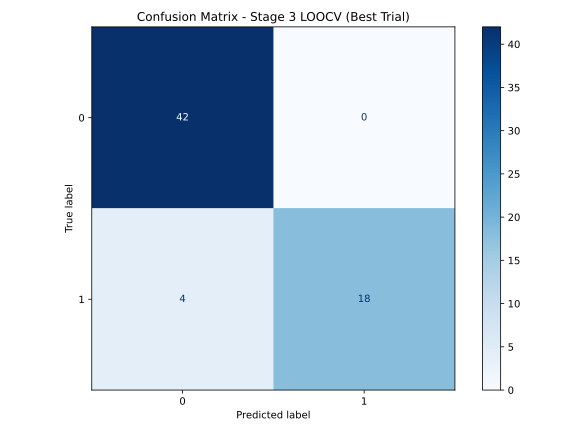

In [34]:
# Visualize confusion matrix for LOOCV
plot_confusion_matrix_loocv(final_study, y, config)

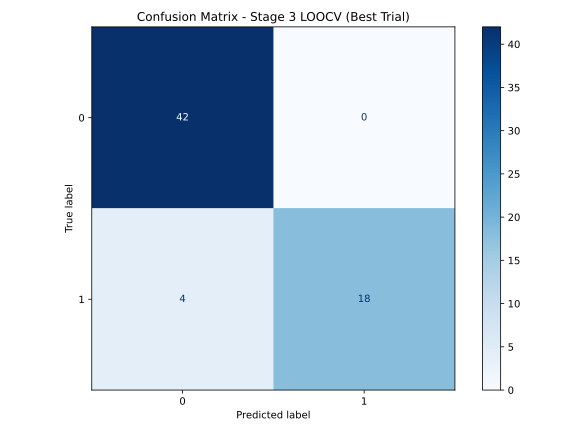

In [35]:
# Visualize confusion matrix for LOOCV
plot_confusion_matrix_loocv(final_study, y, config)

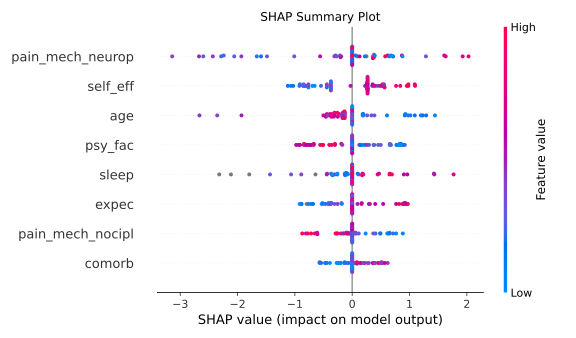

In [36]:
# Visualize SHAP summary for LOOCV
plot_shap_summary_loocv(best_trial, final_features, X, rng, config)

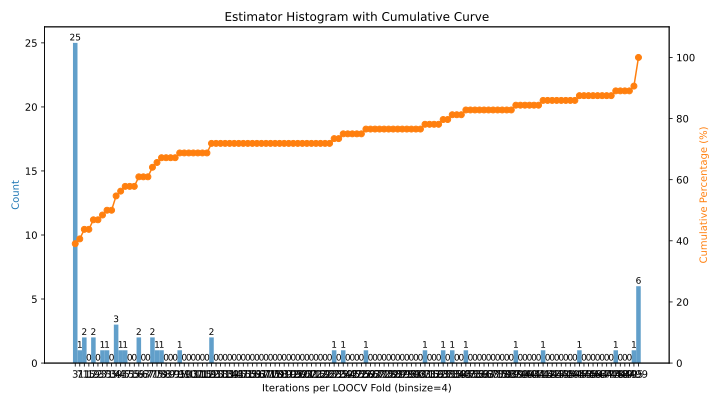

In [37]:
# Visualize iterations histogram for LOOCV
plot_iterations_histogram_loocv(best_trial, config)

# Stage 3: Ensemble Training and Evaluation
Train an ensemble of models using stratified k-fold cross-validation. Aggregate predictions via majority voting on the holdout set, and visualize ensemble performance and feature importance for comprehensive assessment.

---

In [38]:
ensemble_runner = EnsembleStudyRunner(config=config,
                                      numerical_param_df=numerical_param_df,
                                      categorical_param_df=categorical_param_df)

ensemble_result = ensemble_runner.run_final_study(X, y, final_features)

  0%|          | 0/200 [00:00<?, ?it/s]

Number of finished trials:  200


,Trial ID,F1_Score_0,F1_Score_1,ROC_AUC
8,118,0.638963,0.599161,0.673889
26,170,0.638963,0.599161,0.673889
0,6,0.721813,0.586853,0.725278
3,55,0.721813,0.586853,0.725278
4,57,0.721813,0.586853,0.725278
7,110,0.721813,0.586853,0.725278
11,127,0.721813,0.586853,0.725278
15,148,0.721813,0.586853,0.725278
16,150,0.721813,0.586853,0.725278
23,166,0.721813,0.586853,0.725278


Best Trial ID: 118
  Final Features: ['age', 'pain_mech_nocipl', 'psy_fac', 'expec', 'pain_mech_neurop', 'comorb', 'self_eff', 'sleep']
  Params:
    verbose: -1
    objective: binary
    n_jobs: 1
    num_threads: 1
    tree_learner: serial
    deterministic: True
    seed: 42
    feature_fraction_seed: 42
    data_random_seed: 42
    max_bin: 255
    metric: binary_logloss
    boosting_type: gbdt
    is_unbalance: False
    scale_pos_weight: 1.9090909090909092
    force_col_wise: True
    subsample: 0.8362113103502999
    learning_rate: 0.6075103372659397
    feature_fraction: 0.50418936773843
    max_depth: 3
    min_child_weight: 2
    grow_policy: leaf
Estimators:  [1, 16, 30, 3, 1]

Average Classification Report Across Folds:
              precision    recall  f1-score   support
           0      0.814     0.550     0.639         8
           1      0.500     0.780     0.599         4

    accuracy                          0.624        12
   macro avg      0.657     0.665     0.6

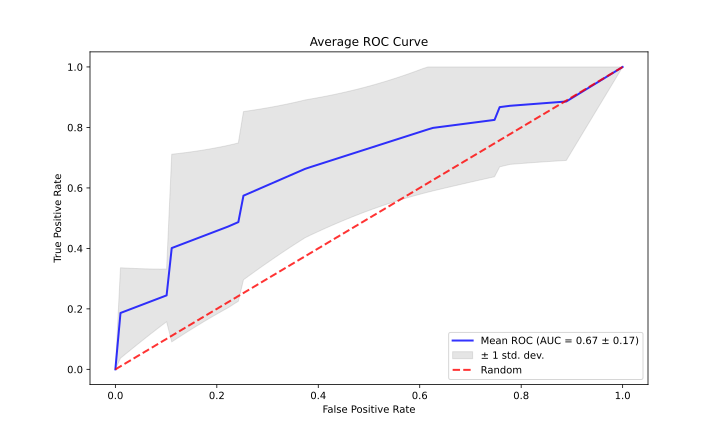

In [39]:
# Visualize average ROC curve for ensemble
plot_average_roc_curve_ensemble(ensemble_result["best_trial"], config)
# This plot shows the average ROC curve for the ensemble model, summarizing its discrimination performance across folds.

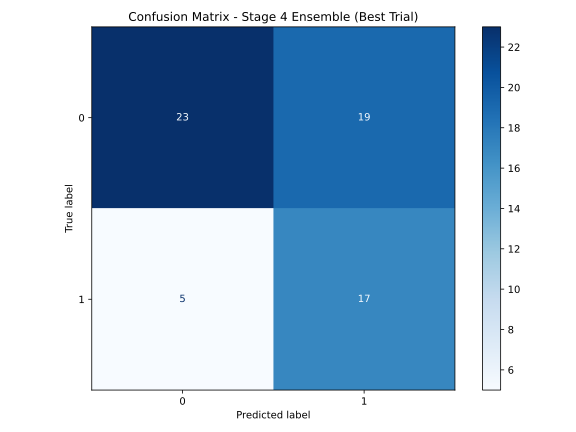

In [40]:
# Visualize confusion matrix for ensemble
plot_confusion_matrix_ensemble(ensemble_result["best_trial"], config)

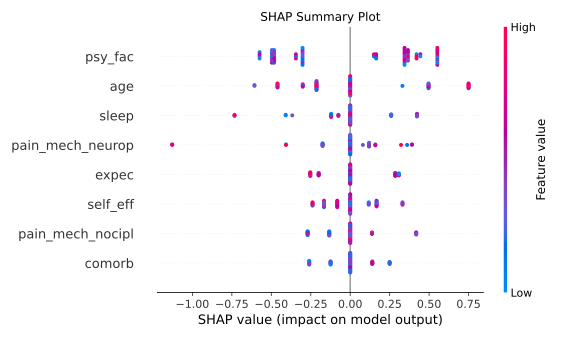

In [41]:
# Visualize SHAP summary for ensemble best trial
plot_shap_summary_ensemble(ensemble_result["best_trial"], X[final_features], final_features, config, rng)
# This plot provides a global view of feature importance and the direction of their effects for the ensemble model.

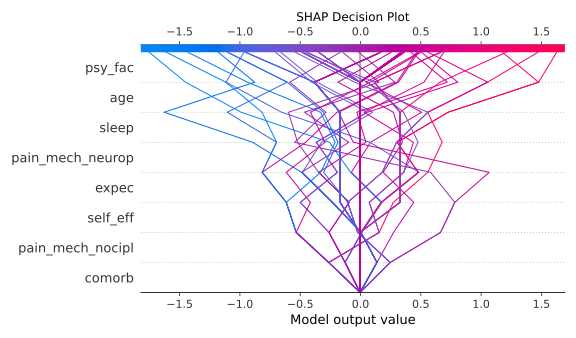

In [42]:
# Visualize SHAP decision plot for ensemble best trial
plot_shap_decision_ensemble(ensemble_result["best_trial"], X[final_features], final_features, config)
# This plot shows how individual features contribute to the model's decision for each sample in the ensemble, helping to interpret model predictions.

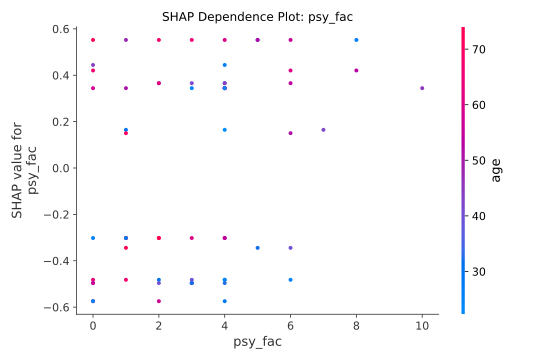

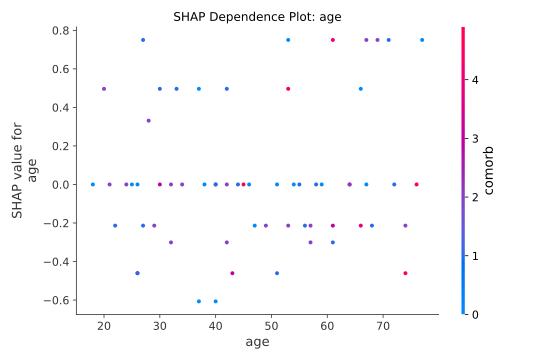

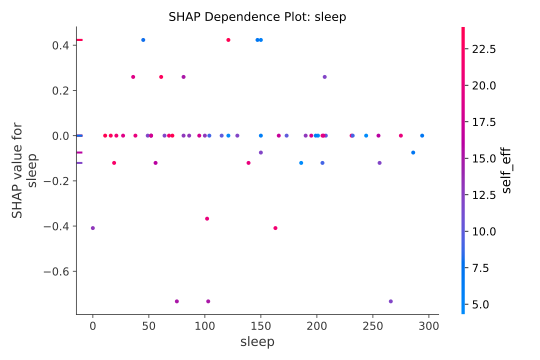

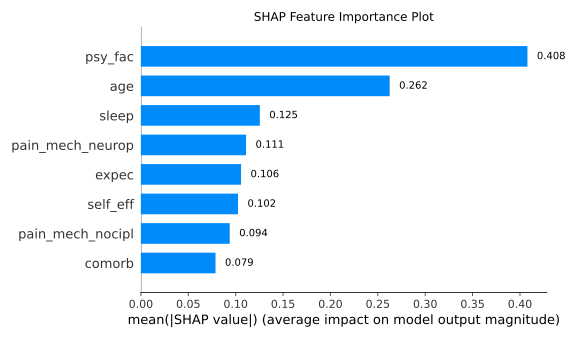

In [43]:
plot_shap_dependence_ensemble(ensemble_result["best_trial"], X[final_features], final_features, config, max_features=3)
plot_shap_feature_importance_ensemble(ensemble_result["best_trial"], X[final_features], final_features, config, rng)

  0%|          | 0/8 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.67      0.67      0.67         3

    accuracy                           0.75         8
   macro avg       0.73      0.73      0.73         8
weighted avg       0.75      0.75      0.75         8



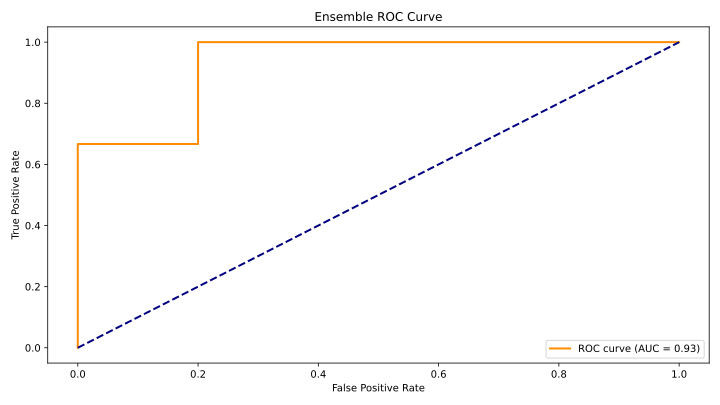

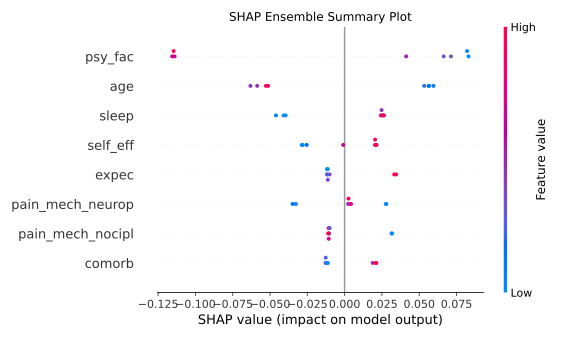

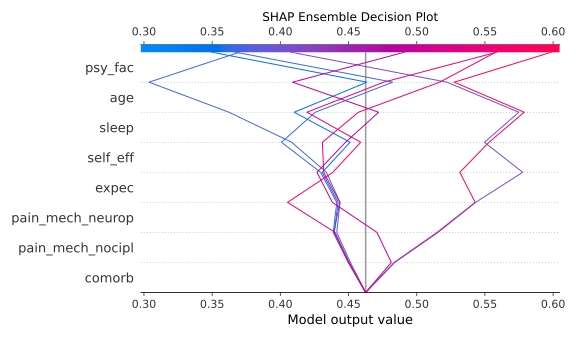

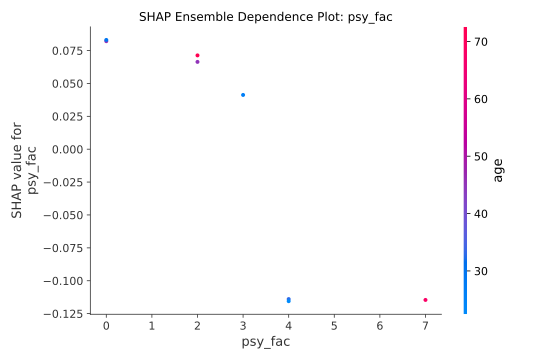

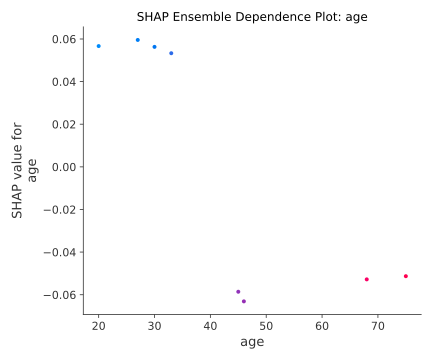

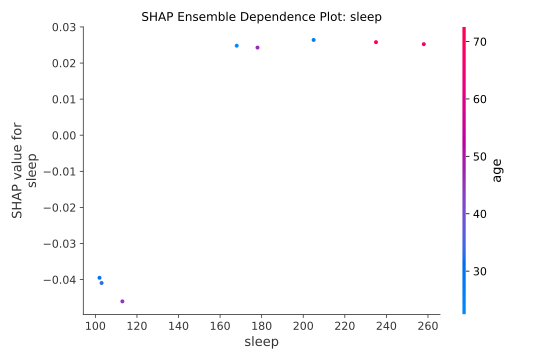

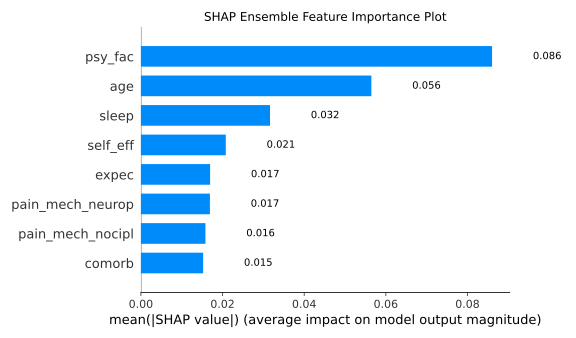

In [44]:
results = ensemble_runner.evaluate_ensemble(
    best_trial=ensemble_result["best_trial"],
    holdout_X=holdout_X,
    holdout_y=holdout_y,
    final_features=final_features,
    create_dataset=create_dataset
)

print(results["report"])  # Optional: check classification report

visualize_ensemble_results(results, final_features, config, rng)